In [43]:
import pandas as pd
import lightgbm as lgb
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

# Load train and test data

In [44]:
train_path = "../../data/processed/train_data.csv"  # Replace with your train file path
test_path = "../../data/processed/test_data.csv"  # Replace with your test file path

# Load data
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

# Split features and target
X_train = train_data.drop(columns=["target", "id"])  # Drop target and id
y_train = train_data["target"]

X_test = test_data.drop(columns=["target", "id"])  # Drop target and id
y_test = test_data["target"]


# Train an initial LightGBM model

In [45]:
lgbm_model = lgb.LGBMClassifier(objective="binary", random_state=42, is_unbalance=True)
lgbm_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 416, number of negative: 430
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191315
[LightGBM] [Info] Number of data points in the train set: 846, number of used features: 753
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491726 -> initscore=-0.033100
[LightGBM] [Info] Start training from score -0.033100
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(is_unbalance=True, objective='binary', random_state=42)

# Compute SHAP values

In [46]:
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(X_train)

C:\Users\unknow\Desktop\IASD S1\Parkinson_disease_classification\venv\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


# Compute the mean absolute SHAP values for each feature

In [47]:
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)  # Use shap_values[1] for the positive class in binary classification
mnabsshapval = np.mean(mean_abs_shap_values)


# Calculate mean absolute SHAP values

In [48]:
shap_importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Mean Absolute SHAP Value": mean_abs_shap_values
}).sort_values(by="Mean Absolute SHAP Value", ascending=False)


print("Top Features by SHAP Importance:\n", shap_importance_df)

Top Features by SHAP Importance:
                         Feature  Mean Absolute SHAP Value
132         std_6th_delta_delta                  1.031568
125  std_delta_delta_log_energy                  0.707844
440       tqwt_TKEO_mean_dec_12                  0.451619
417     tqwt_entropy_log_dec_25                  0.281849
477        tqwt_TKEO_std_dec_13                  0.270539
..                          ...                       ...
39                  GNE_SNR_SEO                  0.000000
305     app_LT_TKEO_mean_5_coef                  0.000000
306     app_LT_TKEO_mean_6_coef                  0.000000
5              numPeriodsPulses                  0.000000
12                    ddpJitter                  0.000000

[753 rows x 2 columns]


# Plot the distribution of mean absolute SHAP values

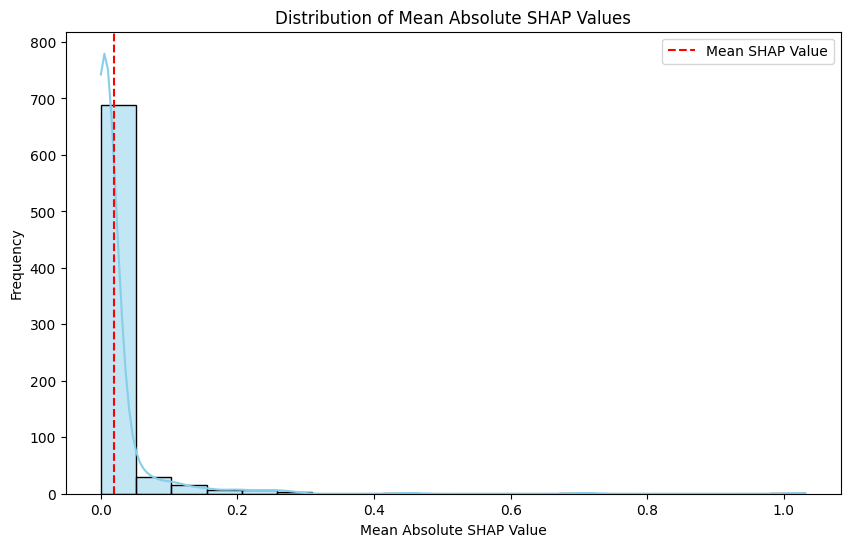

In [49]:
plt.figure(figsize=(10, 6))
sns.histplot(mean_abs_shap_values, bins=20, kde=True, color="skyblue")
plt.axvline(x=mnabsshapval, color="red", linestyle="--", label="Mean SHAP Value")
plt.title("Distribution of Mean Absolute SHAP Values")
plt.xlabel("Mean Absolute SHAP Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Plot SHAP summary

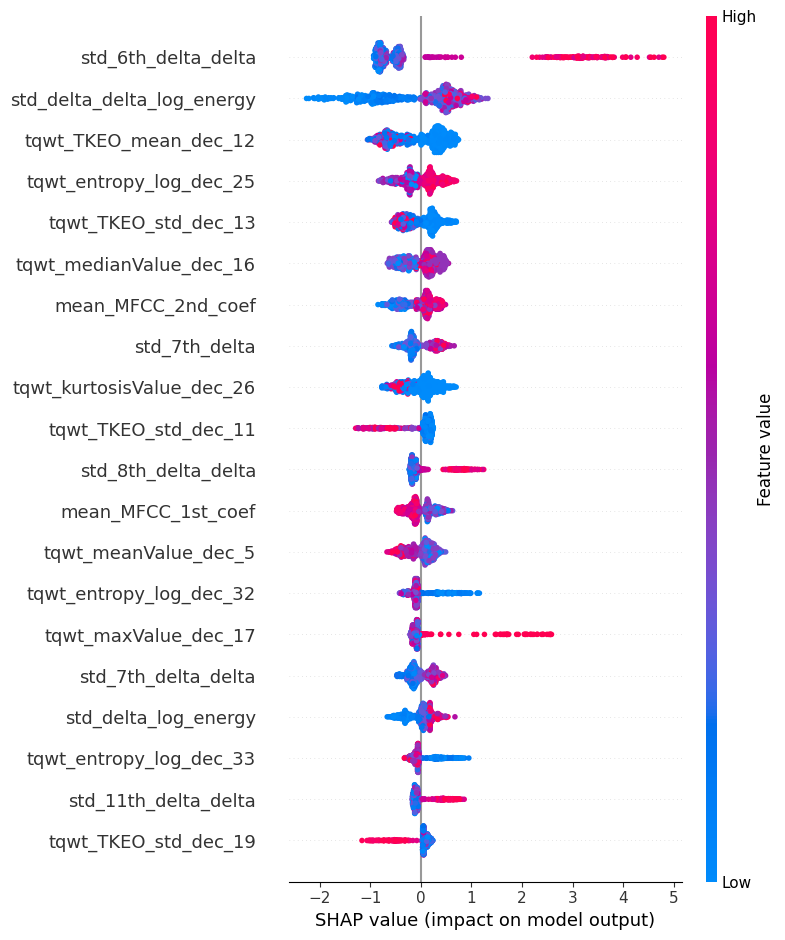

In [50]:
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)

# Drop features with SHAP values less than the mean

In [51]:
features_to_keep = shap_importance_df[shap_importance_df["Mean Absolute SHAP Value"] > mnabsshapval]["Feature"]
X_train_reduced1 = X_train[features_to_keep]
X_test_reduced1 = X_test[features_to_keep]


# Recalculate SHAP importance after the first reduction

In [52]:

shap_importance_df_reduced = shap_importance_df[shap_importance_df["Feature"].isin(features_to_keep)].reset_index(drop=True)


# Compute cumulative contribution

In [53]:
shap_importance_df_reduced["Cumulative Contribution"] = shap_importance_df_reduced[
    "Mean Absolute SHAP Value"
].cumsum() / shap_importance_df_reduced["Mean Absolute SHAP Value"].sum()

# Plot cumulative contribution

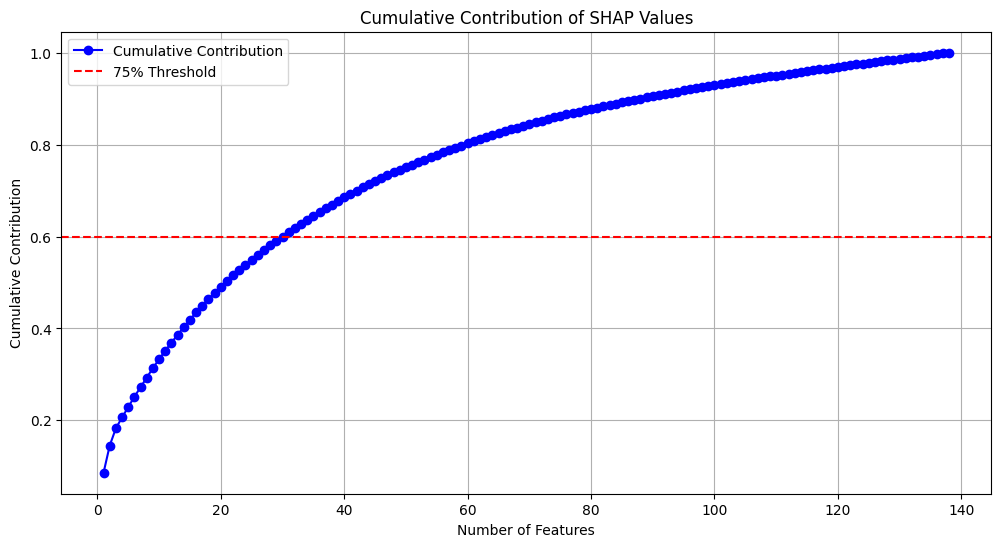

In [54]:
plt.figure(figsize=(12, 6))
plt.plot(
    range(1, len(shap_importance_df_reduced) + 1),
    shap_importance_df_reduced["Cumulative Contribution"],
    marker="o",
    linestyle="-",
    color="blue",
    label="Cumulative Contribution"
)
plt.axhline(y=0.6, color="red", linestyle="--", label="75% Threshold")
plt.title("Cumulative Contribution of SHAP Values")
plt.xlabel("Number of Features")
plt.ylabel("Cumulative Contribution")
plt.legend()
plt.grid()
plt.show()


# Keep features contributing up to the threashhold of 60%

In [55]:
selected_features = shap_importance_df_reduced[
    shap_importance_df_reduced["Cumulative Contribution"] <= 0.6
]["Feature"]

# Final reduced dataset
X_train_reduced2 = X_train_reduced1[selected_features]
X_test_reduced2 = X_test_reduced1[selected_features]

# Save combined datasets to CSV


In [56]:
train_combined = pd.concat([X_train_reduced2, y_train], axis=1)
test_combined = pd.concat([X_test_reduced2, y_test], axis=1)

train_combined.to_csv("../../data/processed/Data_Of_Selected_Features/Train_SelectedFeatures_Shap.csv", index=False)
test_combined.to_csv("../../data/processed/Data_Of_Selected_Features/Test_SelectedFeatures_Shap.csv", index=False)


In [57]:
print(f"Original number of features: {X_train.shape[1]}")
print(f"Number of features after dropping SHAP < mean: {X_train_reduced1.shape[1]}")
print(f"Number of features after cumulative contribution: {X_train_reduced2.shape[1]}")

Original number of features: 753
Number of features after dropping SHAP < mean: 138
Number of features after cumulative contribution: 30
